In [21]:
import pandas as pd
import numpy as np
import boto3
import io
import random
from PIL import Image
import tensorflow as tf

# Initialize S3 resource
s3 = boto3.resource('s3')
bucket_name = 'cancerdetection-datasource'
train_prefix = 'trainset/'
test_prefix = 'testset/'

# Load labels CSV file from S3
def load_labels_from_s3(bucket_name, labels_file):
    obj = s3.Object(bucket_name, labels_file)
    labels_df = pd.read_csv(io.BytesIO(obj.get()['Body'].read()))
    return labels_df

# Load image from S3 and preprocess it
def load_image_from_s3(bucket_name, image_key, target_size=(224, 224)):
    obj = s3.Object(bucket_name, image_key)
    img = Image.open(io.BytesIO(obj.get()['Body'].read()))
    img = img.resize(target_size)  # Resize the image to a standard size
    img = np.array(img)  # Convert image to a numpy array
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Load labels
labels_df = load_labels_from_s3(bucket_name, 'trainset/_labels.csv')

# Load all image paths from the 'trainset/' folder
image_paths = [obj.key for obj in s3.Bucket(bucket_name).objects.filter(Prefix=train_prefix)]

# Initialize the list for image paths and labels
image_labels = []

# Loop through all the image paths and match the image name (without path and extension) with the labels
for image_path in image_paths:
    # Extract image name without directory path and extension
    image_name = image_path.split('/')[-1].split('.')[0]
    
    # Find the corresponding label from the labels DataFrame
    label = labels_df[labels_df['id'] == image_name]['label'].values
    
    # If a matching label is found, append the image path and label to the list
    if len(label) > 0:
        image_labels.append((image_path, label[0]))

# Debugging: Check if labels were properly matched
print(f"Matched image labels: {image_labels[:10]}")  # Print the first 10 for verification

# Randomly sample 800 training images and 300 test images
random.shuffle(image_labels)  # Shuffle the data to ensure randomness
train_image_labels = image_labels[:800]  # Select first 800 for training
test_image_labels = image_labels[800:1100]  # Select next 300 for testing

# Prepare training data
train_images = []
train_labels = []
for image_path, label in train_image_labels:
    image = load_image_from_s3(bucket_name, image_path)
    train_images.append(image)
    train_labels.append(label)

# Prepare testing data
test_images = []
test_labels = []
for image_path, label in test_image_labels:
    image = load_image_from_s3(bucket_name, image_path)
    test_images.append(image)
    test_labels.append(label)

# Convert to numpy arrays for TensorFlow compatibility
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Check the shapes of the datasets
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

# Define a simple CNN model with Lambda layer for rescaling
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x / 255.0, input_shape=(224, 224, 3)),  # Manually rescale the image pixels
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Change to appropriate loss for multi-class if needed
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=5, validation_data=test_dataset)


Matched image labels: [('trainset/000a2a35668f04edebc0b06d5d133ad90c93a044.tif', 1), ('trainset/002b0c44150cc70f36e837c52f10f4f15e543544.tif', 1), ('trainset/003cc1395bcb283c0290d9516c456e8d97656365.tif', 0), ('trainset/00562e6224fa598d12ee94c87f935259940892d8.tif', 0), ('trainset/0078e95985529a875454c645d3e385c163578bbc.tif', 0), ('trainset/00b2b01146d6a6fac654ab0aee515d1262275351.tif', 1), ('trainset/010214de5ebebfac6b16f5cae037134f520ab07c.tif', 1), ('trainset/0108ace495e0f1ee5b9b55dd05e1218e6234f46b.tif', 0), ('trainset/014c8c4390fbc31a0cc5d54bbc756454abdc48c6.tif', 0), ('trainset/0165843894384551520807b6bfde8425e2f3cc90.tif', 0)]
Training images shape: (800, 224, 224, 3)
Training labels shape: (800,)
Test images shape: (300, 224, 224, 3)
Test labels shape: (300,)


2024-12-04 04:41:37.805599: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 963379200 exceeds 10% of free system memory.


Epoch 1/5
25/25 [==============================] - 51s 2s/step - loss: 0.7052 - accuracy: 0.5287 - val_loss: 0.6808 - val_accuracy: 0.6200
Epoch 2/5
25/25 [==============================] - 48s 2s/step - loss: 0.6846 - accuracy: 0.5692 - val_loss: 0.6644 - val_accuracy: 0.6200
Epoch 3/5
25/25 [==============================] - 50s 2s/step - loss: 0.6933 - accuracy: 0.5692 - val_loss: 0.6677 - val_accuracy: 0.6200
Epoch 4/5
25/25 [==============================] - 48s 2s/step - loss: 0.6866 - accuracy: 0.5692 - val_loss: 0.6646 - val_accuracy: 0.6200
Epoch 5/5
25/25 [==============================] - 49s 2s/step - loss: 0.6884 - accuracy: 0.5692 - val_loss: 0.6660 - val_accuracy: 0.6200


In [22]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


10/10 [==============================] - 5s 496ms/step - loss: 0.6660 - accuracy: 0.6200
Test Loss: 0.6659585237503052
Test Accuracy: 0.6200000047683716


In [23]:
# Predict on new images
predictions = model.predict(test_dataset)
# Predictions will be probabilities, so you might want to convert them to class labels
predicted_labels = (predictions > 0.5).astype("int32")


In [24]:
# Iterate through test images and print predictions vs. true labels
for image, true_label in test_dataset:
    predicted_label = model.predict(image)  # Get prediction
    predicted_label = (predicted_label > 0.5).astype("int32")  # Convert to class label
    print(f"True label: {true_label}, Predicted label: {predicted_label}")


True label: [0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0], Predicted label: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True label: [1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1], Predicted label: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True label: [0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0], Predicted label: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True label: [1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0], Predicted label: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0

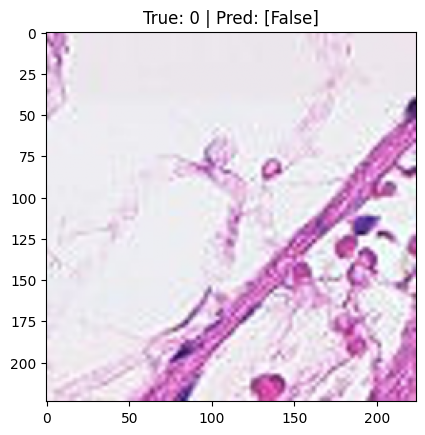

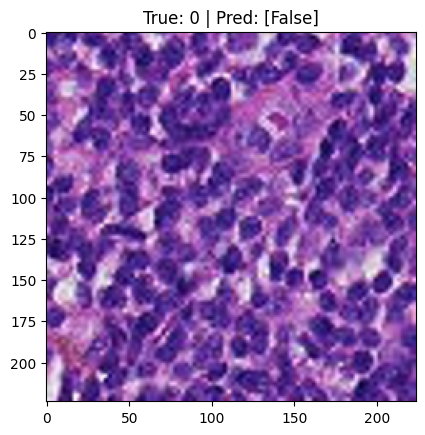

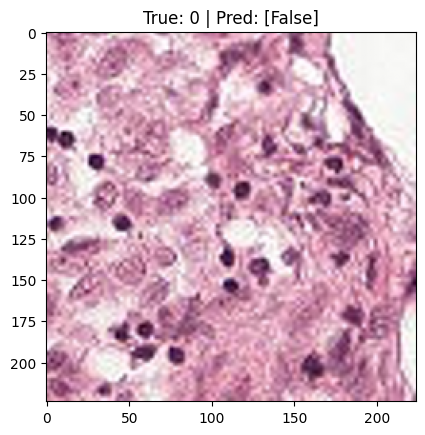

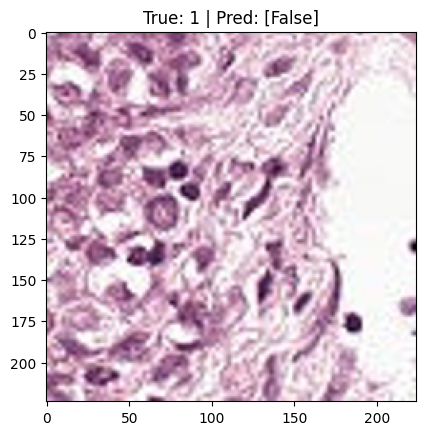

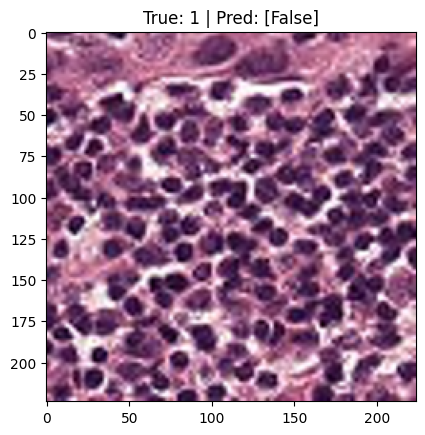

In [25]:
import matplotlib.pyplot as plt

# Get a batch of test images and their labels
images, labels = next(iter(test_dataset))

# Predict on the batch
predictions = model.predict(images)

# Plot the first few test images with true and predicted labels
for i in range(min(5, len(images))):  # Display up to 5 images
    plt.imshow(images[i])
    plt.title(f"True: {labels[i]} | Pred: {predictions[i] > 0.5}")
    plt.show()


In [27]:
import boto3
from tensorflow.keras.models import load_model
from botocore.exceptions import ClientError

bucket_name = 'my-models-bucket'
model_key = 'trained_model.h5'
local_model_path = 'trained_model.h5'

s3 = boto3.client('s3')

try:
    s3.download_file(bucket_name, model_key, local_model_path)
    print("Model downloaded successfully!")
    model = load_model(local_model_path)
except ClientError as e:
    print(f"Error downloading file: {e}")


Error downloading file: An error occurred (403) when calling the HeadObject operation: Forbidden


In [29]:
from tensorflow.keras.models import save_model

# Save the model in the .h5 format
model.save('/Users/dhruvalokesh/Desktop/Cancer_trained_model/trained_model.h5')


PermissionDeniedError: /Users; Permission denied